## Multiple Linear Regression
### and backward elimination
#### education indicators

The purpose of this notebook is to 
* apply Multiple Linear Regression to the preprocessed dataset
* apply backward elimination to the model
* ultimately find out the independent variables (World Development Idicators) which influence the dependent variable (Happy Planet Index) the most.

The model will be applied to the "wdi_hpi_2016_education" dataset, which was created in the Data Preprocessing JNotebook. This dataset is based on
* the Happy Planet Index for 2016 (see https://happyplanetindex.org/),
* the World Development Indicators (1960 - 2019) by the World Bank (see https://datacatalog.worldbank.org/dataset/world-development-indicators)

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
dataset = pd.read_pickle('../data/wdi_hpi_2016_education.pkl')
picture_name = '../data/pictures/Education_corr.jpg'

In [3]:
# Standardize data for the model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit dataset to scaler object
dataset_scaled = dataset.iloc[:, 1:].values    # Exclude Country column 
scaler.fit(dataset_scaled)

# Transform data into scaled data
dataset_scaled = pd.DataFrame(scaler.transform(dataset_scaled))

In [4]:
# Split dataset into X (matrix of independent variables) and y (vector of dependent variable)
X = dataset_scaled.iloc[:, 1:-1].values
y = dataset_scaled.iloc[:, dataset_scaled.shape[1]-1].values

# Split datasets into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0)    # no split, as model is not used for prediction

In [5]:
# Fit Multiple Linear Regression Model to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# Predict the Test set results
#y_pred = regressor.predict(X_test)

In [7]:
# Reduce less important variables with Backward Elimination
import statsmodels.regression.linear_model as sm

# for statsmodel to understand the multiple linear regression equation a new column with b0 equals one is required (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
X_opt = np.append(arr = np.ones((len(X), 1)).astype(int), values = X, axis = 1)   # Add X to the newly created array of 1s
#X_opt = X_opt[:, list(range(X_opt.shape[1]))]

X_cols = dataset.columns[1:-1].tolist()    # save headers to determin most important variables later
X_cols.insert(0,'b0')

X_mod1, X_mod2 = X_opt.copy(), X_opt.copy()
X_cols_mod1, X_cols_mod2 = X_cols.copy(), X_cols.copy()

regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     7.312
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           9.24e-07
Time:                        17:19:33   Log-Likelihood:                -177.29
No. Observations:                 139   AIC:                             368.6
Df Residuals:                     132   BIC:                             389.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.012e-16      0.075  -2.67e-15      1.000      -0.149       0.149
x1             0.4630      0.102      4.543      0.000       0.261       0.665
x2            -0.1248      0.082     -1.515      0.132      -0.288       0.038
x3             0.0963      0.120      0.800      0.425      -0.142       0.335
x4            -0.0401      0.099     -0.404      0.687      -0.236       0.156
x5             0.1248      0.089      1.402      0.163      -0.051       0.301
x6             0.0125      0.091      0.137      0.891      -0.168       0.193
==============================================================================
Omnibus:                        1.962   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.687
Skew:                           0.137   Prob(JB):                        0.430
Kurtosis:                       2.535   Cond. No.                         2.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
def backward_elimination(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    x = np.delete(x, j, 1)
                    X_cols_mod.pop(j)
    regressor_OLS.summary()
    return x, X_cols_mod
             
backward_elimination(X_mod1, X_cols_mod1)
print(X_cols_mod1)

['SE.COM.DURS', 'SE.XPD.TOTL.GD.ZS']


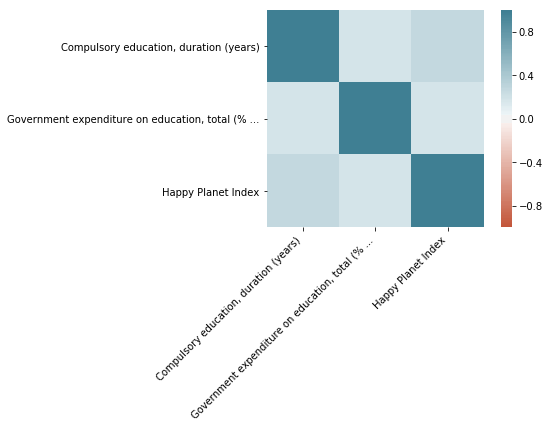

In [9]:
# Create Correlation Matrix with Seaborn (only remaining columns from backward elimination)

# Translate WDI abbreviations into meaningsful indicator descriptions
chosen_columns = pd.read_pickle('../data/WDI_chosen_columns.pkl')

corr_cols_descr = []
for ind in X_cols_mod1:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

# Import Seaborn and plot Correlation Matrix
import seaborn as sns

corr_cols = X_cols_mod1.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
# and adjusted R² is improved
def backward_elimination_r2(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, axis = 1)
                    tmp_col = X_cols_mod.pop(j)
                    tmp_regressor = sm.OLS(endog = y, exog = x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        X_cols_rollback = X_cols_mod.append(tmp_col)
                        #x = np.hstack((x, temp[:,[0,j]]))
                        #x = np.delete(x, j, 1)
                        #X_cols_mod = X_cols_mod.append(tmp_col)
                        print (regressor_OLS.summary())
                        return x_rollback, X_cols_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x, X_cols_mod
    
backward_elimination_r2(X_mod2, X_cols_mod2)
print(X_cols_mod2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.70
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           2.40e-08
Time:                        17:19:33   Log-Likelihood:                -177.71
No. Observations:                 139   AIC:                             361.4
Df Residuals:                     136   BIC:                             370.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5135      0.078      6.559      0.0

,SE.COM.DURS,SE.TER.ENRR,SE.XPD.TOTL.GD.ZS,SE.PRM.CMPT.ZS,Happy Planet Index
SE.COM.DURS,1.000000,0.126104,0.180806,0.204705,0.273462
SE.TER.ENRR,0.126104,1.000000,0.210085,0.318105,0.152237
SE.XPD.TOTL.GD.ZS,0.180806,0.210085,1.000000,0.228729,0.186278
SE.PRM.CMPT.ZS,0.204705,0.318105,0.228729,1.000000,0.466892
Happy Planet Index,0.273462,0.152237,0.186278,0.466892,1.000000


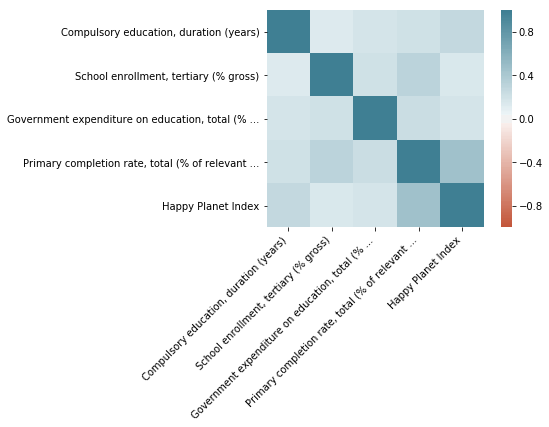

In [11]:
# Create Correlation Matrix with Seaborn

# Translate WDI abbreviations into meaningsful indicator descriptions
corr_cols_descr = []
for ind in X_cols_mod2:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

corr_cols = X_cols_mod2.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Save Correlation Matrix to 
plt.savefig(picture_name, format = 'jpg', optimize = True, bbox_inches = 'tight')

# Return Correlation Matrix
corr